# MitoEM challenge
This notebook takes a folder of tiff masks predictions and turns it into hd5 format for submission to [https://mitoem.grand-challenge.org/](https://mitoem.grand-challenge.org/).
Run through the cells twice - once for Human and one for Rat. Then zip the output files together and upload.

In [1]:
import os
import h5py
import numpy as np
from skimage.io import imread
from tqdm import tqdm
from scipy import ndimage
import tifffile as tiff
import scipy
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# data_dir = "./EM30-R-im/im/"
# tiff_dir = "./OUTPUT/EM30-R-all/PREDICTIONS/"
# h5file_name = '1_rat_instance_seg_pred.h5'

data_dir = "./EM30-H-im-pad/im_pad/"
tiff_dir = "./OUTPUT/EM30-H-all/PREDICTIONS/"
h5file_name = '0_human_instance_seg_pred.h5'

In [3]:
%%time
# Read the tiff files, assume have sorteable filenames 001.tif, 002.tif etc.

tiff_files = [f for f in os.listdir(tiff_dir) if f.endswith(".tif")]
tiff_files.sort()

# Load the first TIFF file to get its dimensions
first_tiff = tiff.imread(os.path.join(tiff_dir, tiff_files[0]))
height, width = first_tiff.shape
num_slices = len(tiff_files)

# Create a numpy array to store the volume
volume = np.zeros((num_slices, height, width), dtype=np.uint8)

# Iterate through TIFF files and populate a volume
for i, tiff_file in enumerate(tiff_files):
    #print(tiff_file)
    tiff_data = tiff.imread(os.path.join(tiff_dir, tiff_file))
    volume[i, :, :] = tiff_data
    
print(volume.shape)

(500, 4096, 4096)
CPU times: total: 14.4 s
Wall time: 14.5 s


In [4]:
# Downsample the volume as required
# volume = volume[::1,::2,::2]
# volume = volume[::1,0:4096:1,0:4096:1]

In [5]:
%%time
# Smooth the data... This step is not strictly required, but may improve or worsen results.

# Fill the holes
selem = np.ones((1,1,1))
opened_data = scipy.ndimage.binary_opening(volume, structure=selem, iterations=2)

CPU times: total: 1min 56s
Wall time: 1min 56s


In [6]:
%%time
# pred_stack = (volume / 255).astype('int64')
pred_stack, nr_objects = ndimage.label(opened_data)
print("Number of objects {}".format(nr_objects))

Number of objects 46553
CPU times: total: 7min 32s
Wall time: 8min 13s


In [7]:
pred_stack.shape

(500, 4096, 4096)

In [8]:
# Free up some memory if needed
# volume=None
# opened_data=None

In [9]:
# Create the HDF5 file (using LZF compression to save space)
h5f = h5py.File(h5file_name, 'w')
h5f.create_dataset('dataset_1', data=pred_stack, compression="lzf")
h5f.close()


# Done! 
Re-run the above. Otherwise continue on to make some diagnostic plots.

In [10]:
%%time
# Read the original files. These are not needed for submission, but good for diagnostics.
data_files = [f for f in os.listdir(data_dir) if f.endswith(".png")]
data_files.sort()

# Subset the datafiles to just the testing images
data_files = data_files[501:]

# Load the first png file to get its dimensions
image = Image.open(os.path.join(data_dir, data_files[0]))
image_array = np.array(image)

height, width = image_array.shape
num_slices = len(data_files)

# Create a numpy array to store the volume
volume_data = np.zeros((num_slices, height, width), dtype=np.uint8)

# Iterate through TIFF files and populate a volume
for i, data_file in enumerate(data_files):
    #print(tiff_file)
    image = Image.open(os.path.join(data_dir, data_file))
    image_array = np.array(image)
    volume_data[i, :, :] = image_array
    
print(volume_data.shape)

(539, 5120, 5120)
CPU times: total: 2min 34s
Wall time: 2min 39s


In [11]:
# Downsample the volume as required
# volume_data = volume_data[::1,::2,::2]
# volume_data = volume_data[::1,0:4096:1,0:4096:1]

In [12]:
# Visualise one of your results
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_diagnostic(gt, pred):
    # Plottin
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the target image
    print(np.min(gt), np.max(gt), np.mean(gt), np.median(gt))
    ll1=ax.imshow(gt, cmap='winter', alpha=0.5)

    # Plot Prediction in red with opacity
    print(np.min(pred), np.max(pred), np.mean(pred), np.median(pred))
    pred_binary = np.ma.masked_where(pred == False, pred)
    ll2=ax.imshow(pred_binary, cmap='autumn_r', alpha=0.5,vmin=0, vmax=1)
    
    plt.show()


0 255 135.8256434249878 145.0
False True 0.03648871183395386 0.0


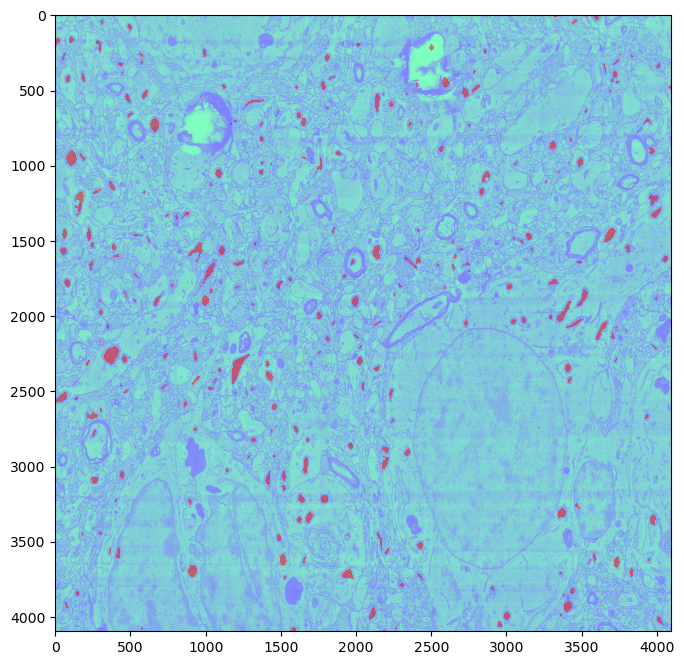

In [15]:
plot_diagnostic(volume_data[330,:,:], opened_data[330,:,:])

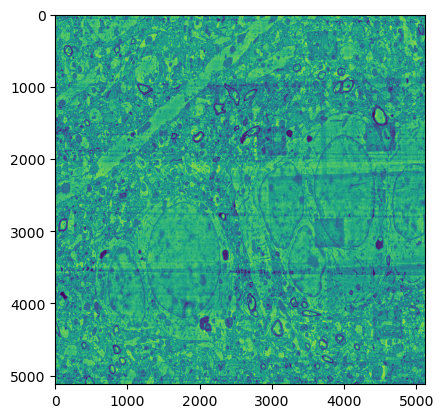

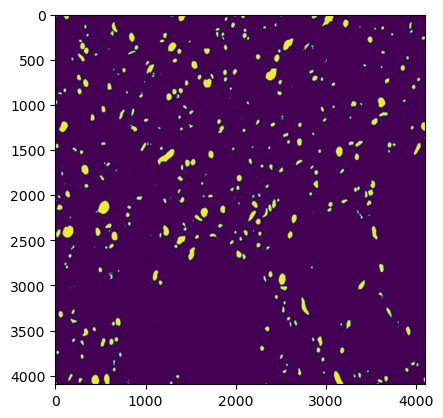

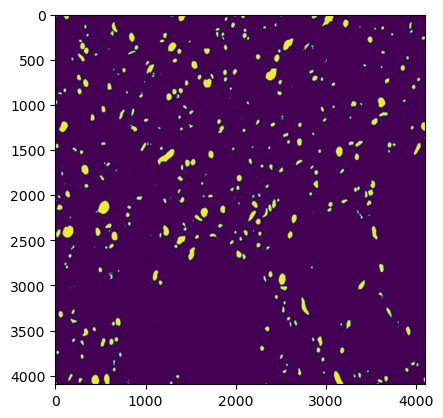

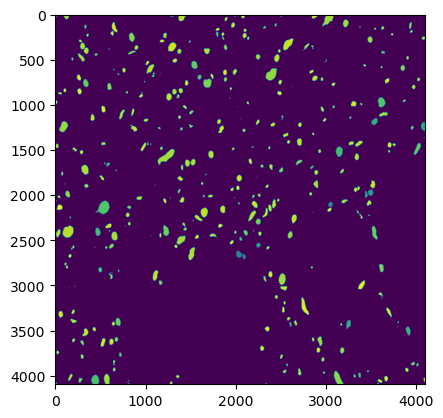

In [14]:
plt.imshow(volume_data[100,:,:])
plt.show()
plt.imshow(volume[100,:,:])
plt.show()
plt.imshow(opened_data[100,:,:])
plt.show()
plt.imshow(pred_stack[100,:,:])
plt.show()